<a href="https://colab.research.google.com/github/Marco-Minniti/LoG_Blob_Detector/blob/main/LoG_blob_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>ASSIGNMENT 7: Blob detector with LoG filter<h2>

<h4><b>Author</b>: Minniti Marco<h4>
<h4>Mat: 617439<h4>


In [15]:
import sys
import os

current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

!git clone https://github.com/Marco-Minniti/LoG_Blob_Detector.git

Cloning into 'LoG_Blob_Detector'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 2), reused 19 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 4.25 MiB | 2.04 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [2]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

<b>sigmasAndFilters</b>: the function calculates and returns an array of sigmas and the corresponding filter sizes for a given number of scales, a factor of k, and an initial sigma. The filter is calculated as the product of sigma and 6, rounded to the nearest integer. If the filter size is even, it is incremented by 1 to make it odd, which is useful for convolution.

<b>laplacianOfGaussian</b>: calculates and returns an array of LoG filters, for each, values are calculated using the relevant formula.

<b>convolution</b>: the function convolves the image with each of the LoG filters and returns an array of convolved images. Before convolution, padding is performed to the image. The convolution is performed by multiplying the LoG filter by the corresponding portion of the image and summing the results.

In [4]:
def sigmasAndFilters(number_scales,k,initial_sigma):
    sigmas = []
    for i in range(number_scales):
        sigma_i = initial_sigma*(k**i)
        sigmas.append(sigma_i)
    #creating the filter size for each sigmas
    filters_dim = [round(i*6) for i in sigmas]
    for i in range(len(filters_dim)):
        if filters_dim[i]%2 == 0: # if the size of the filter is even, then make it odd, useful for convolution
            filters_dim[i] = filters_dim[i]+1 
    return sigmas,filters_dim


def laplacianOfGaussian(k,sigmas,number_scales,filters_dim):
    LoG = [] # array that contains the LoG filters for each scale
    for i in range(number_scales):
        LoG_i = np.zeros((filters_dim[i],filters_dim[i])) # for each scale, create an empty LoG filter of size h[i] x h[i] where h[i] is the filter size for scale i
        # Defining the range of values that x and y can take when calculating the values of the LoG filter
        initial = int(-(math.floor(filters_dim[i]/2)))
        end = int(math.floor(filters_dim[i]/2))
        for x in range(initial,end+1):
            for y in range(initial,end+1):
                LoG_i[x+end,y+end] = (-1/(math.pi*(sigmas[i]**2)))*(1-(((x**2)+(y**2))/(2*(sigmas[i]**2))))*np.exp(-((x**2)+(y**2))/(2*(sigmas[i]**2)))
        LoG.append(LoG_i)
    return LoG

In [5]:
def convolution(image, LoG, number_scales, filters_dim):
    row = image.shape[0]
    col = image.shape[1]
    conv_imgs = []
    for i in range(number_scales):
        LoG[i] = np.flipud(np.fliplr(LoG[i])) # flip the LoG filter in both vertical and horizontal directions, useful for convolution
        matrix = np.zeros_like(image) 
        s = int(math.floor(filters_dim[i]/2))+1 # size of the padding that is added to the image before convolution
        padded = np.zeros((row + filters_dim[i]+1, col + filters_dim[i]+1))   
        padded[s:-s, s:-s] = image
        # Convolution
        for x in range(row): 
            for y in range(col):
                matrix[x,y]=(LoG[i]*padded[x:x+filters_dim[i],y:y+filters_dim[i]]).sum()  
        conv_imgs.append(matrix)
    return conv_imgs 

<b>Function to find minima</b> 

For each scale, scrolls through each pixel in the convolved image. 

For each pixel, it checks whether the pixel's value is a local maximum by comparing it with the values of neighboring pixels in a 3x3x3 surround (which includes the current scale, the previous scale, and the next scale). 

If the pixel value is greater than the threshold and is a local maximum, then it is considered a blob.

In [6]:
def find_Maxima(img,conv_imgs,sigmas,number_scales,threshold):
    row = img.shape[0]
    col = img.shape[1]
    blobs = [] # array that contains the location of the blobs in the image for each scale
    for n in range(number_scales):
        blob = []
        blob_radius = int(math.sqrt(2)*sigmas[n]) # radius of the circle that is drawn around the blob proportional to the sigma
        for x in range(row):
            for y in range(col):
                flag = 'min'
                for u in range(-1,2):
                    for i in range(-1,2):
                        for j in range(-1,2):
                            if x+i >= 0 and y+j >= 0 and x+i < row and y+j < col and n+u >= 0 and n+u < number_scales:
                                if conv_imgs[n][x,y] > threshold:
                                    if conv_imgs[n][x,y] < conv_imgs[n+u][x+i,y+j]: flag = 'not min'   
                                else: flag = 'not min'
                if flag == 'min':
                    if x-blob_radius > 0 and y-blob_radius > 0 and x+blob_radius < row-1 and y+blob_radius < col-1:
                        blob.append([x,y])
                        #cv2.circle(img, (y, x), blob_radius, (0,0,255), 1)
                        cv2.circle(img, (y, x), blob_radius, (0,0,255), 2)
        blobs.append(blob)
    return img

<h4><b>TEST</b></h4>

In [7]:
def run_test (img, img1, number_scales, k, initial_sigma, threshold):
    img = img/255
    sigmas, filters_dim = sigmasAndFilters(number_scales,k,initial_sigma)
    LoG = laplacianOfGaussian(k,sigmas,number_scales,filters_dim)
    conv_imgs = convolution(img,LoG,number_scales,filters_dim)
    img1 = find_Maxima(img1,conv_imgs,sigmas,number_scales,threshold)
    return img1


<h4><b>Test on image 1</b></h4>

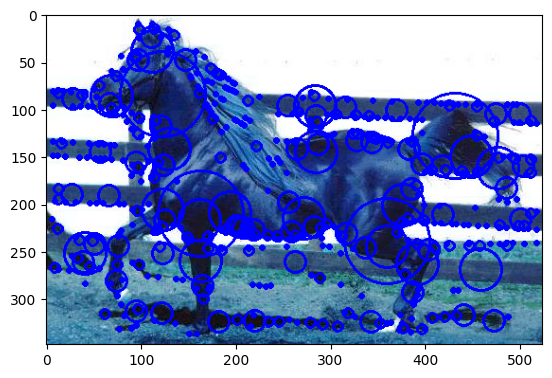

True

In [8]:
img = cv2.imread('LoG_Blob_Detector/images/horse007.png', 0)
img1 = cv2.imread('LoG_Blob_Detector/images/horse007.png')

number_scales = 5 # smaller scale will detect small details (small blobs), while a larger scale will detect larger details, used to generate several LoG filters_dim
k = 2 # scale factor
initial_sigma = 2 
threshold = 0.1

img1 = run_test(img, img1, number_scales, k, initial_sigma, threshold)

plt.imshow(img1)
plt.show()
cv2.imwrite('LoG_Blob_Detector/results/horse007_blob.png',img1)

Applying the blob detector to the following image, one can observe the presence dk many small blobs, this is probably due to the various hyperparameters set as the various threads and their relative size (thus dependent on sigma and the scaling factor) that allowed them to be detected. In addition, the threshold (treshold) also affects this detection.

Although the filter seems to be more effective in detecting smaller details, we can see how it is able to successfully detect larger and more distinctive features in the image thus detecting larger blobs, especially in the head, legs and tail part of the horse, i.e., areas that seem to be quite uniform in terms of intensity.

In general, the overall result obtained seems good.


<h4><b>Test on image 2</b></h4>

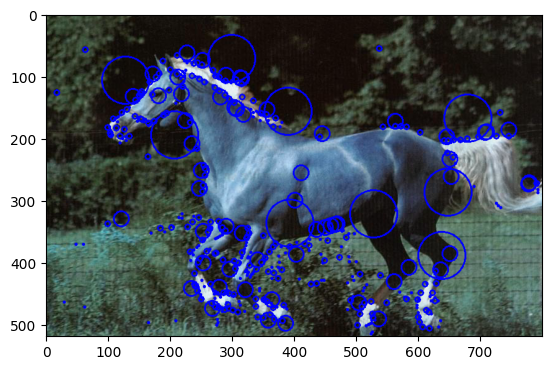

True

In [13]:
img = cv2.imread('LoG_Blob_Detector/images/horse205.png', 0)
img1 = cv2.imread('LoG_Blob_Detector/images/horse205.png')

number_scales = 5 # smaller scale will detect small details (small blobs), while a larger scale will detect larger details, used to generate several LoG filters_dim
k = 3 # scale factor
initial_sigma = 1
threshold = 0.1

img1 = run_test(img, img1, number_scales, k, initial_sigma, threshold)

plt.imshow(img1)
plt.show()
cv2.imwrite('LoG_Blob_Detector/results/horse205_blob.png',img1)

Considering a slight change in the parameters of the initial sigma (initial_sigma) and multiplicative factor (k), in this image we can see as before that the presence of small blobs is prevalent, but at the same time there are more large blobs present in greater numbers which, especially in the head part highlight the horse silhouette compared to the predominantly black background.

The set of blobs identified, in general, seem to follow the horse's silhouette probably due to the difference in color shades with the background.


<h4><b>Test on image 3</b></h4>

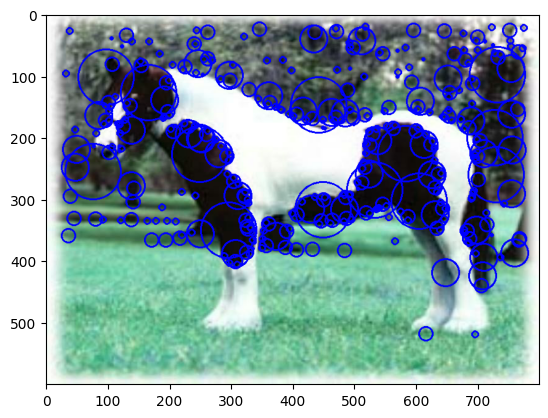

True

In [10]:
img = cv2.imread('LoG_Blob_Detector/images/horse300.png', 0)
img1 = cv2.imread('LoG_Blob_Detector/images/horse300.png')

number_scales = 5 # smaller scale will detect small details (small blobs), while a larger scale will detect larger details, used to generate several LoG filters_dim
k = 2 # scale factor
initial_sigma = 2 
threshold = 0.1

img1 = run_test(img, img1, number_scales, k, initial_sigma, threshold)

plt.imshow(img1)
plt.show()
cv2.imwrite('LoG_Blob_Detector/results/horse300_blob.png',img1)

Finally, in this last image, the detections of the blobs in the dark parts of the horse are certainly striking, a symptom of the correct distinction between dark and light parts where obviously the color intesities have a distinct change.

Again, the survey seems fairly consistent

<h4><b>CONCLUSIONS</b></h4>

While implementing the code, the biggest challenge was to figure out how to find local maxima in the convolved image (as well as how to convolve between the image and the LoG filter).

In general, I tried to do blob detection on multiple scales, thus generating different LoG filters with different sizes, determined by different sigma values, thus allowing me to detect blobs of different sizes. For each scale, I convolve the image with the relevant filter and then search for local maxima in the convolved image thus ensuring that blobs are identified as local maxima at the different scales.

A possible improvement would be to implement a normalization method for pixel values after convolution. Currently, the intensity of detected blobs depends on the scale: larger blobs (detected at larger scales) will be larger than smaller blobs (detected at smaller scales).